Interpolation completed in 43.59 seconds.


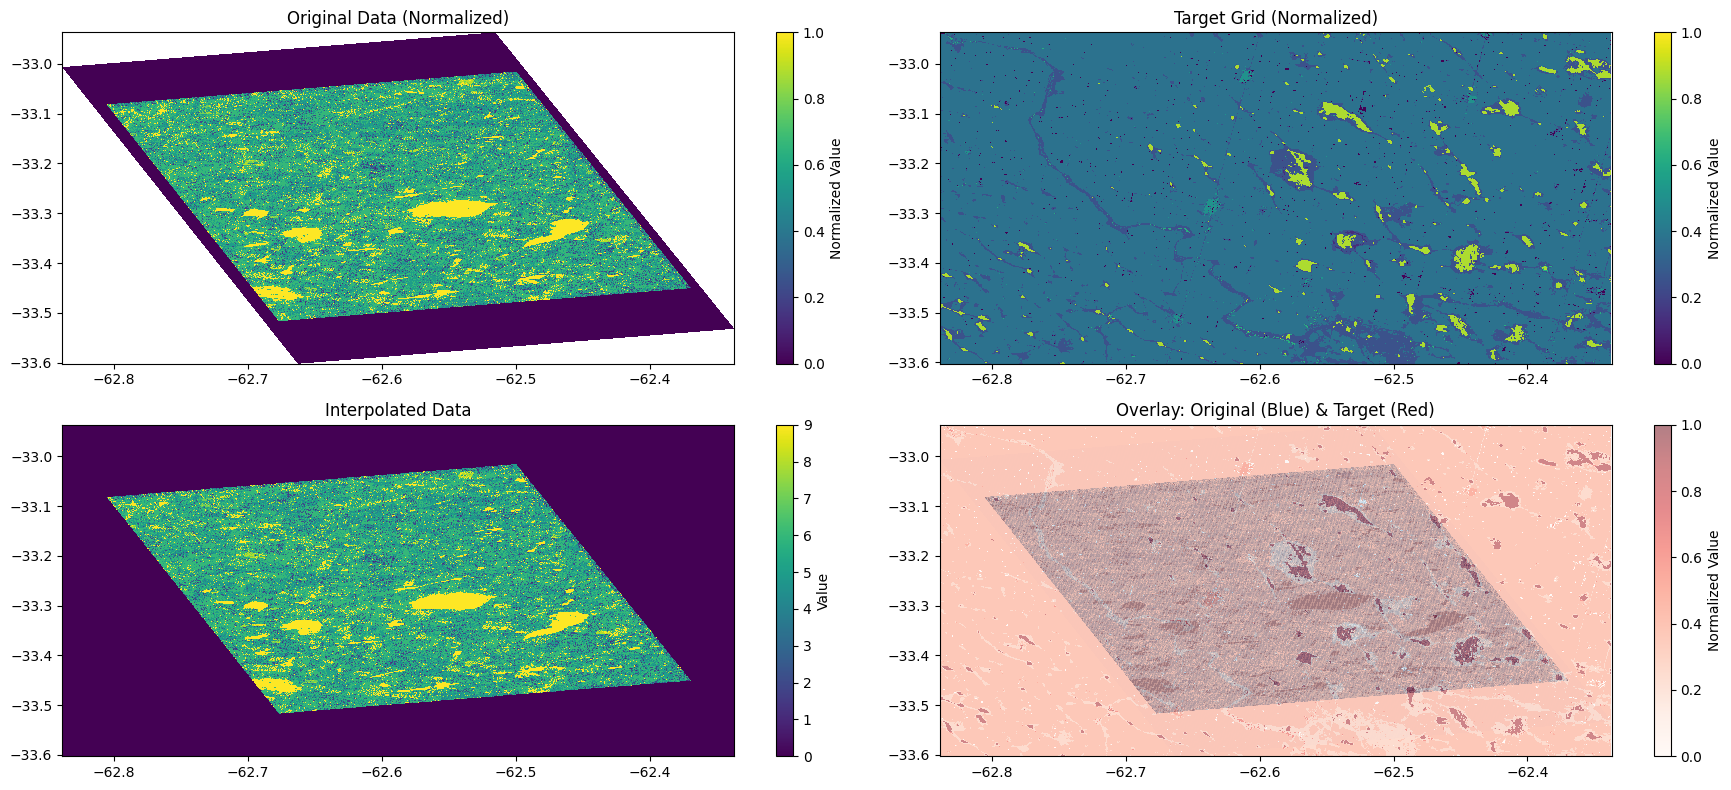

Interpolation completed and saved to interpolated_result.nc


In [ ]:
import os, sys
import numpy as np
import xarray as xr
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

import time

def interpolate_xarray(xarray_1, xarray_2):
    """
    Interpolate xarray_1 onto the geographic grid of xarray_2.

    Parameters:
        xarray_1 (xarray.DataArray): The source DataArray with data and 2D lat/lon meshes.
        xarray_2 (xarray.DataArray): The target DataArray with 2D lat/lon meshes.

    Returns:
        xarray.DataArray: Interpolated DataArray aligned with the target grid.
    """
    # Extract data and coordinates from xarray_1
    source_data = xarray_1.data
    source_lat = xarray_1['latitude'].values  # 2D latitude
    source_lon = xarray_1['longitude'].values  # 2D longitude

    # Extract target grid from xarray_2
    target_lat = xarray_2['latitude'].values  # 2D target latitude
    target_lon = xarray_2['longitude'].values  # 2D target longitude

    # Flatten the source grid and values
    source_points = np.column_stack((source_lat.ravel(), source_lon.ravel()))
    source_values = source_data.values.ravel()  # Access the underlying NumPy array

    # Interpolation points
    target_points = np.column_stack((target_lat.ravel(), target_lon.ravel()))

    # Perform the interpolation
    start_time = time.time()
    interpolated_values = griddata(
        source_points, source_values, target_points, method='nearest'  # Use nearest neighbor interpolation
    )

    # Reshape the interpolated values to match the target grid
    interpolated_data = interpolated_values.reshape(target_lat.shape)
    end_time = time.time()
    print(f"Interpolation completed in {end_time - start_time:.2f} seconds.")

    # Create a new xarray.DataArray with the interpolated data
    interpolated_xarray = xr.DataArray(
        interpolated_data,
        coords={
            'latitude': (('y', 'x'), target_lat),
            'longitude': (('y', 'x'), target_lon)
        },
        dims=['y', 'x']
    )

    return interpolated_xarray

# Load the xarrays from the specified paths
base_dir = "/home/renaud/Polarimetric_landcover/data/SatSao_MonteMaiz_cordoba"
xarray_1 = xr.open_dataset(os.path.join(base_dir, "Z_xarray.nc"))
xarray_2 = xr.open_dataset(os.path.join(base_dir, "esa_xarray.nc"))

# sys.exit()
xslice = slice(2000, 2500)  
yslice = slice(8000, 8600)

xslice = slice(None)  
yslice = slice(None)

# Example: Extract by index
xarray_1_subset = xarray_1.isel(y=yslice, x=xslice)
# Interpolate xarray_1 onto xarray_2's grid
# interpolated_xarray = interpolate_xarray(xarray_1_subset, xarray_2)

# # Remove extreme values (e.g., top and bottom 2%) in the original data
# low_percentile = np.nanpercentile(xarray_1.data, 2)
# high_percentile = np.nanpercentile(xarray_1.data, 98)
# xarray_1_clipped = xarray_1.where((xarray_1.data >= low_percentile) & (xarray_1.data <= high_percentile), drop=True)
xarray_1_clipped = xarray_1

# Interpolate xarray_1 onto xarray_2's grid
interpolated_xarray = interpolate_xarray(xarray_1_clipped, xarray_2)

# Save the result to a NetCDF file
interpolated_xarray.to_netcdf(os.path.join(base_dir, "interpolated_result.nc"))

# Plot the original, target, interpolated, and normalized overlay
plt.figure(figsize=(18, 8))

# Normalize data for consistent comparison
xarray_1_min, xarray_1_max = np.nanmin(xarray_1_clipped.data), np.nanmax(xarray_1_clipped.data)
xarray_2_min, xarray_2_max = np.nanmin(xarray_2.data), np.nanmax(xarray_2.data)
xarray_1_normalized = (xarray_1_clipped.data - xarray_1_min) / (xarray_1_max - xarray_1_min)
xarray_2_normalized = (xarray_2.data - xarray_2_min) / (xarray_2_max - xarray_2_min)

# Plot the original data
plt.subplot(2, 2, 1)
plt.pcolormesh(xarray_1['longitude'], xarray_1['latitude'], xarray_1, shading="auto")
plt.title("Original Data (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the target grid
plt.subplot(2, 2, 2)
plt.pcolormesh(xarray_2['longitude'], xarray_2['latitude'], xarray_2, shading="auto")
plt.title("Target Grid (Normalized)")
plt.colorbar(label="Normalized Value")

# Plot the interpolated data
plt.subplot(2, 2, 3)
plt.pcolormesh(interpolated_xarray['longitude'], interpolated_xarray['latitude'], interpolated_xarray.values, shading="auto")
plt.title("Interpolated Data")
plt.colorbar(label="Value")

# Overlay normalized original and target data
plt.subplot(2, 2, 4)
plt.pcolormesh(xarray_1['longitude'], xarray_1['latitude'], xarray_1_normalized, shading="auto", alpha=0.5, cmap="Blues")
plt.pcolormesh(xarray_2['longitude'], xarray_2['latitude'], xarray_2_normalized, shading="auto", alpha=0.5, cmap="Reds")
plt.title("Overlay: Original (Blue) & Target (Red)")
plt.colorbar(label="Normalized Value")

plt.tight_layout()
plt.show()

print("Interpolation completed and saved to interpolated_result.nc")


<xarray.DataArray (y: 25, x: 40)> Size: 8kB
array([[            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,    

/tmp/ipykernel_39344/1097932421.py:51: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x_src, y_src, data_src, shading="auto")


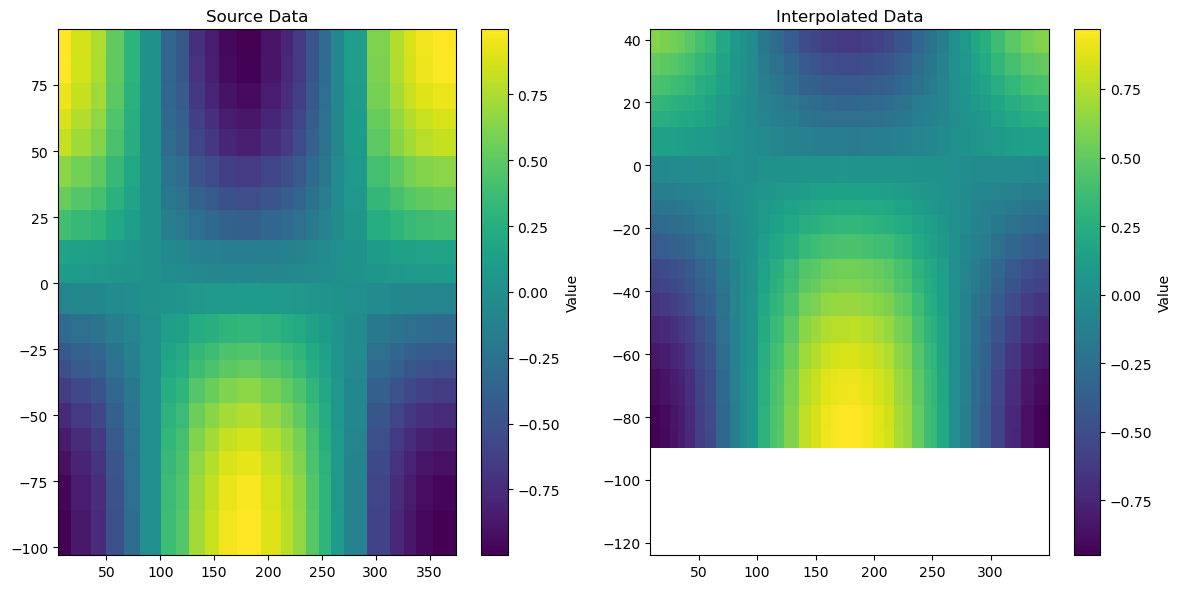

In [4]:
# Create irregular 2D source grid (latitude and longitude)
y_src, x_src = np.meshgrid(
    np.linspace(-90, 90, 20) + np.random.uniform(-5, 5, 20),
    np.linspace(0, 360, 30) + np.random.uniform(-10, 10, 30),
    indexing="ij"
)

# Create source data (e.g., temperature values)
data_src = np.sin(np.radians(y_src)) * np.cos(np.radians(x_src))

# Build xarray_1 with 2D lat/lon and data
xarray_1 = xr.DataArray(
    data_src,
    coords={
        "latitude_mesh": (("y", "x"), y_src),
        "longitude_mesh": (("y", "x"), x_src)
    },
    dims=["y", "x"]
)

# Create irregular 2D target grid (latitude and longitude)
y_tgt, x_tgt = np.meshgrid(
    np.linspace(-120, 40, 25) + np.random.uniform(-3, 3, 25),
    np.linspace(10, 350, 40) + np.random.uniform(-5, 5, 40),
    indexing="ij"
)

# Build xarray_2 with 2D lat/lon grid
xarray_2 = xr.DataArray(
    np.empty_like(y_tgt),  # Dummy data for now
    coords={
        "latitude_mesh": (("y", "x"), y_tgt),
        "longitude_mesh": (("y", "x"), x_tgt)
    },
    dims=["y", "x"]
)

# Use the interpolation function
interpolated_xarray = interpolate_xarray(xarray_1, xarray_2)

# Print and visualize results
print(interpolated_xarray)

# Plot source and interpolated data for comparison (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
plt.pcolormesh(x_src, y_src, data_src, shading="auto")
plt.title("Source Data")
plt.colorbar(label="Value")

# Interpolated data
plt.subplot(1, 2, 2)
plt.pcolormesh(x_tgt, y_tgt, interpolated_xarray.values, shading="auto")
plt.title("Interpolated Data")
plt.colorbar(label="Value")

plt.tight_layout()
plt.show()
